<a href="https://colab.research.google.com/github/alexis24694/proyecto-ml-2020-1/blob/master/proyecto_ml_2020_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto del Curso Aprendizaje Automatico
# Mice Protein Expression Data Set - Grupo D

In [ ]:
#Importando las librerias necesarias para la experimentacion
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as sk
import lightgbm as lgb

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

from matplotlib.pyplot import figure




/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Descargar el dataset de un archivo subido al drive mediante su ID
!wget -O Data_Cortex_Nuclear.csv "https://drive.google.com/uc?id=1NDjOlxkHDEBQ08SlO1EAPDPeoISjsY05&export=download"

--2020-07-06 02:28:59--  https://drive.google.com/uc?id=1NDjOlxkHDEBQ08SlO1EAPDPeoISjsY05&export=download
Resolving drive.google.com (drive.google.com)... 108.177.125.138, 108.177.125.100, 108.177.125.101, ...
Connecting to drive.google.com (drive.google.com)|108.177.125.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-5k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/0edcodkl4p25v930jgpe4ahhv5aj3dld/1594002525000/07257263427831096354/*/1NDjOlxkHDEBQ08SlO1EAPDPeoISjsY05?e=download [following]
--2020-07-06 02:29:00--  https://doc-0k-5k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/0edcodkl4p25v930jgpe4ahhv5aj3dld/1594002525000/07257263427831096354/*/1NDjOlxkHDEBQ08SlO1EAPDPeoISjsY05?e=download
Resolving doc-0k-5k-docs.googleusercontent.com (doc-0k-5k-docs.googleusercontent.com)... 64.233.188.132, 2404:6800:4008:c06::84
Connecting to doc-0k-5k-docs.googleusercontent.com (do

In [39]:
#Cargando el archivo a un dataframe
data = pd.read_csv('Data_Cortex_Nuclear.csv')

In [ ]:
data.shape

(1080, 82)

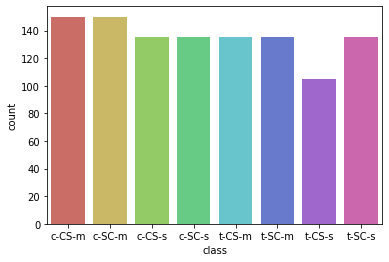

In [ ]:
#Visualizando la distribucion de la variable objetivo
sns.countplot(x="class",data=data,palette="hls")
plt.show()

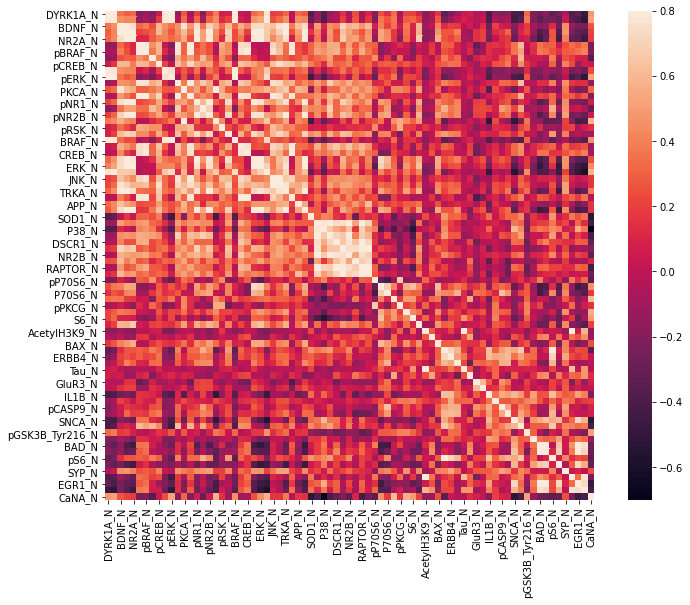

In [ ]:
#Visualizando la matriz de correlacion de los datos
corrmat = data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

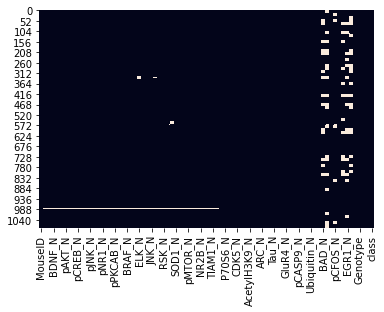

In [ ]:
#Visualizando un mapa de calor de los datos nulos
sns.heatmap(data.isnull(), cbar=False)

# Preprocesamiento de datos

In [40]:
#Calculando el porcentaje de valores nulos
null_percentages = data.isnull().sum(axis=0) / data.shape[0]

#Considerando un umbral de 20%
threshold = 0.2

#Se tienen 2 columnas que superan el umbral de valores nulos
null_percentages[null_percentages > threshold]

#Eliminando las columnas cuyo umbral supera el 20%
data = data.loc[:, data.isnull().sum() < 0.2*data.shape[0]]

#Recodificacion manual de las columnas con valores categoricos
data["Genotype"]=data["Genotype"].replace({"Control":0,"Ts65Dn":1})
data["Treatment"]=data["Treatment"].replace({"Memantine":0,"Saline":1})
data["Behavior"]=data["Behavior"].replace({"C/S":0,"S/C":1})
data["class"]=data["class"].replace({"c-CS-s":0,"c-CS-m":1,"c-SC-s":2,"c-SC-m":3,"t-CS-s":4,"t-CS-m":5,"t-SC-s":6,"t-SC-m":7})

#Inputando la media de los valores de las mediciones
data = data.fillna(data.mean())




# Clasificacion

In [41]:
#Separando las caracteristicas del target
X = data.loc[:, 'DYRK1A_N':'CaNA_N']
y = data['class']

In [42]:
#Separando el conjunto de entrenamiento y prueba (80% entrenamiento - 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Random Forest

Entrenamiento

In [ ]:
#Definiendo los hiperparametros a opmitizar
max_features = [9, 10, 11]
max_depth = [57, 60, 63]
min_samples_leaf = [4]
n_estimators = [1200]

parameter_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf}


rfc = RandomForestClassifier(oob_score = True)
rfc_grid = GridSearchCV(estimator = rfc,
                        scoring = 'f1_micro',   # Se definio en el experimento medir utilizando la metrica f1
                        param_grid = parameter_grid, 
                        cv = 3,          # Validación cruzada 3-fold
                        verbose=2, 
                        n_jobs = -1      # Paralelizar en todos los cores disponibles
                        )

#Entrenando a un modelo Random Forest
#Encontrando los mejores hiperparametros con GridSearchCV
rfc_grid.fit(X_train, y_train)


Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  1.9min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=True, random_state=None,
                                 

Evaluacion del modelo

In [ ]:
rfc_best = rfc_grid.best_estimator_
rfc_prediction = rfc_best.predict(X_test)
rfc_f1_score = metrics.f1_score(y_test, rfc_prediction, average='micro') 
print('Valor de la metrica f1 para el conjunto de prueba:', rfc_f1_score)

Valor de la metrica f1 para el conjunto de prueba: 0.9861111111111112


In [30]:
rfc_best.n_classes_

8

Evaluacion de caracteristicas mas importantes

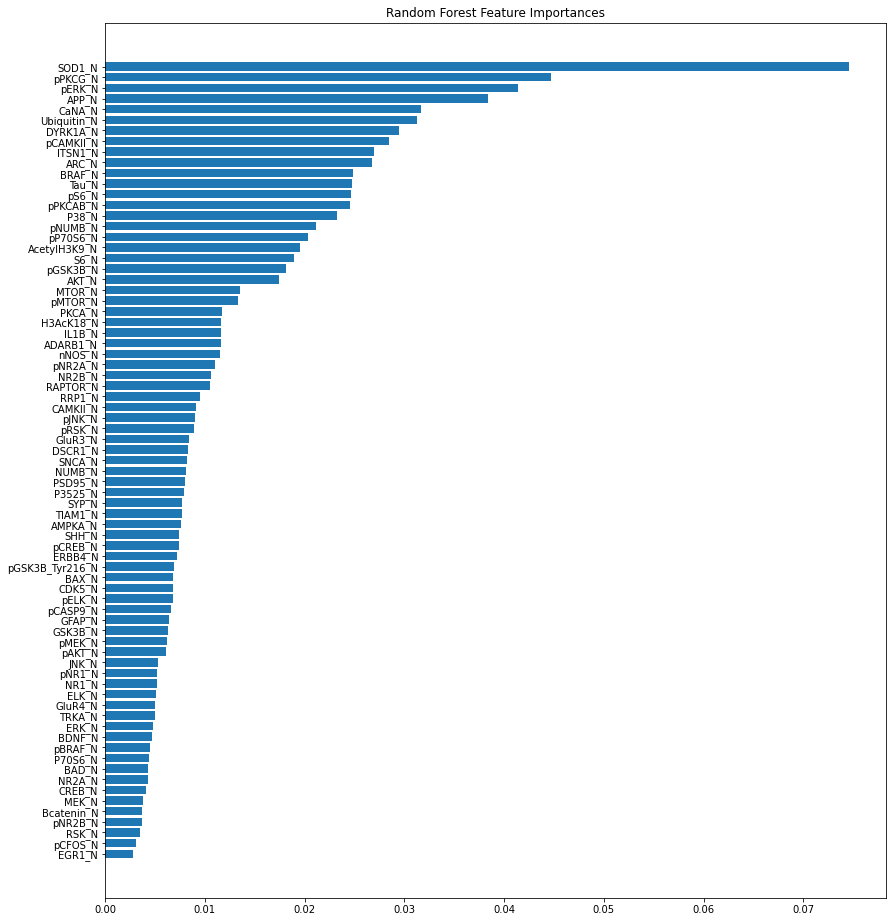

In [ ]:
feature_names = X_train.columns.values
rfc_feature_importances = rfc_best.feature_importances_
sorted_idx = rfc_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots()
ax.barh(y_ticks, rfc_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances")
fig.tight_layout()
fig.set_figheight(15)
fig.set_figwidth(15)


plt.show()

#LightGBM

In [43]:
#Adaptado del Notebook https://www.kaggle.com/pintu161/implementation-of-lightgbm-for-begineers
d_train = lgb.Dataset(X_train, label= y_train)
params = {}
params['learning_rate']= 0.003
params['boosting_type']='gbdt'
params['objective']='multiclass'
params['metric']='multi_error'
params['sub_feature']=0.5
params['num_leaves']= 10
params['min_data']=50
params['max_depth']=10
params['num_class'] = 8

clf= lgb.train(params, d_train, 100)

In [62]:
lgbm_pred_probs = clf.predict(X_test)
lgbm_pred = []

for x in lgbm_pred_probs:
    lgbm_pred.append(np.argmax(x))


lgbm_f1_score = metrics.f1_score(y_test, lgbm_pred, average='micro') 
print('Valor de la metrica f1 para el conjunto de prueba:', lgbm_f1_score)

Valor de la metrica f1 para el conjunto de prueba: 0.8379629629629629


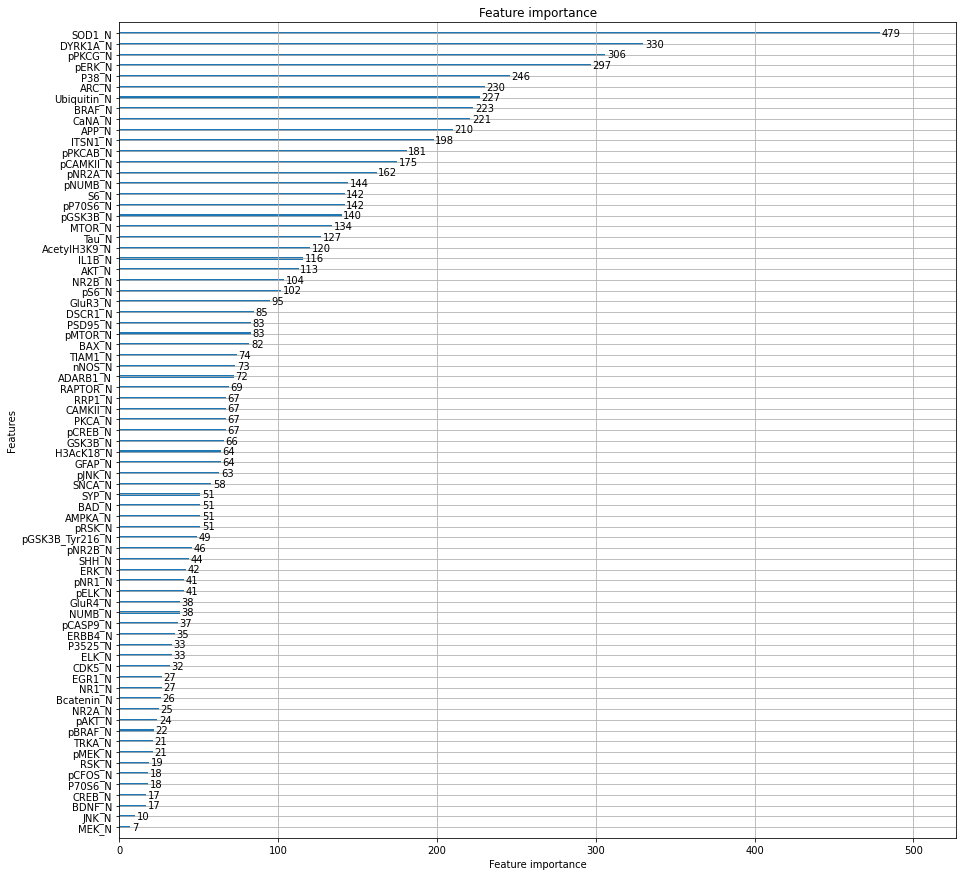

In [54]:
x = lgb.plot_importance(clf)
x.figure.set_figheight(15)
x.figure.set_figwidth(15)

# XGBOOST

In [ ]:
xg_model = xgb.XGBClassifier()
xg_model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="auc",
        eval_set=[(X_train, y_train)])